# DRL Course 2023 Домашнее задание 6 #

Отчет по выполнению домашнего задания, Nikita Sorokin

## Описание алгоритма

### Proximal Policy Optimization (PPO)

Инициализируем политику $ \pi^{\eta} (a|s) $ и $ V^{\theta} (s) $ нейронными сетями. Устанавливаем $ \eta_0 $ и $ \theta_0 $

В цикле по $ k $ для $ k = \overline{1, K} $:

* По политике $ \pi^{\eta} $ получаем траекторию (или несколько) $ \tau = (S_0, \, A_0, \, ... \, S_T) $. Считаем $ (G_0, \, ... \, G_{T-1}) $.

* Определяем лосс как:

$$
Loss_1(\eta) = - \frac{1}{T} \sum_{t=0}^{T-1} \min \left\{ \frac{\pi^{\eta} (A_t | S_t)}{\pi^{\eta_k} (A_t | S_t)} A^{\theta_k} (S_t, A_t) , g_{\varepsilon} (A^{\theta_k} (S_t, A_t)) \right\}
$$

$$
Loss_2(\theta) = \frac{1}{T} \sum_{t=0}^{T-1} A^{\theta} (S_t, A_t),
$$

где $ A^{\theta} (S_t, A_t) $ = 
* $ V^{\theta} (S_t) - G_t \quad $ - advantage, полученный из Монте Карло оценки $ Q $-функции
* $ R_t + \gamma V^{\theta} (S_{t+1}) - V^{\theta} (S_t) \quad $ - advantage, полученный из уравнений Беллмана для $ Q $-функции

и обновляем параметры параметры нейронных сетей:

$$
\eta_{k + 1} \leftarrow \eta_{k} - \alpha_1 \nabla_{\eta} Loss_1(\eta_k), \quad \theta_{k + 1} \leftarrow \theta_{k} - \alpha_2 \nabla_{\theta} Loss_2(\theta_k)
$$

## Задание 1

Написать и исследовать другой способ представления Adavantage функции. Использовать представление вида: 

$$ A(s, a) = r + \gamma V(s') + V(s) , \quad \text{где} \,\, s'  \,\, \text{ - следующее состояние}$$

Для обучения обоих вариаций алгоритма были подобраны следующие гиперпараметры:

```python
episode_n = 50
trajectory_n = 20

gamma = 0.999
batch_size = 128 
epsilon = 0.1 
epoch_n = 30 
pi_lr = 3e-4 
v_lr = 3e-4
```

Архитектура нейронной сети: 3 линейных слоя по 128 нейронов, функция активации ReLU, на последнем слое Tanh

**Замечание**: из-за использования функции активации Tanh на последнем слое выход нейронной сети представляет действительное число в интервале от -1 до 1. В зависимости от задачи необходимо умножать выход нейронной сети на такой множитель, чтобы область определения ее выхода и область определения action совпадали (в случае, если область определения действий не симметрична относительно 0 еще делать сдвиг)

### Default advantage

Реализация алгоритма была представлена на семинаре.

График обучения:

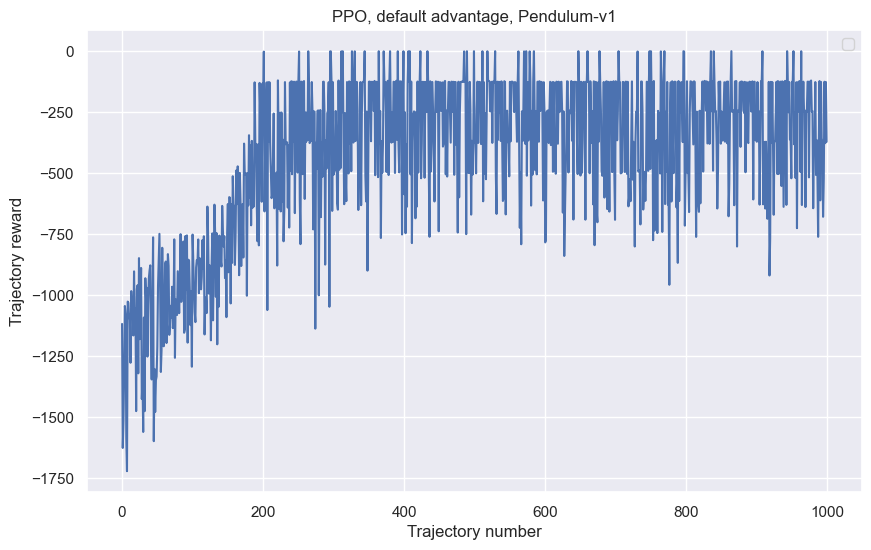

In [1]:
from IPython.display import display, Image
display(Image(filename="pics/ppo_default_pendulum.png"))

Валидация:

**PPO, default advantage, validation_score: -278.2683005264685**

### Bellman advantage

Для реализации были заведены дополнительные массивы dones и next_states, которые использовались для рассчета новой функции advantage:

```python

if advantage == 'default':
    b_advantage = b_returns.detach() - self.v_model(b_states)

if advantage == 'bellman':
    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states.detach()) - self.v_model(b_states) 

```

График обучения:

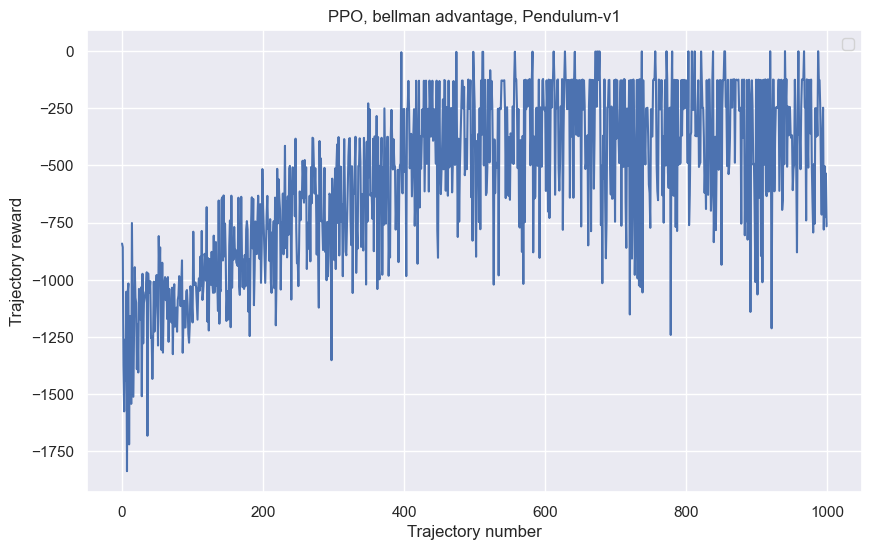

In [2]:
display(Image(filename="pics/ppo_bellman_pendulum.png"))

Валидация:

**PPO, bellman advantage, validation_score: -305.57454480511615**

Вывод: для моих гиперпараметров default advantage обучился чуть более быстрее и стабильнее чем bellman advantage

## Задание 2

Модифицировать PPO для работы в средах с многомерным пространством действий и решить с его помощью LunarLander (результат должен быть больше 100).

Для реализации многомерного PPO было проведено обобщение исходного алгоритма. Например, mean и log_std теперь определяются следующим образом:

```python
logits = self.pi_model(states)
mean, log_std = logits[:, :self.action_dim], logits[:, self.action_dim:]
```

Для агента среды LunarLander-v2 был использован bellman advantage и следующие гиперпараметры:

```python
episode_n = 75
trajectory_n = 10
agent.epoch_n = 20

```
Остальные, как в предыдущем номере.

График обучения:

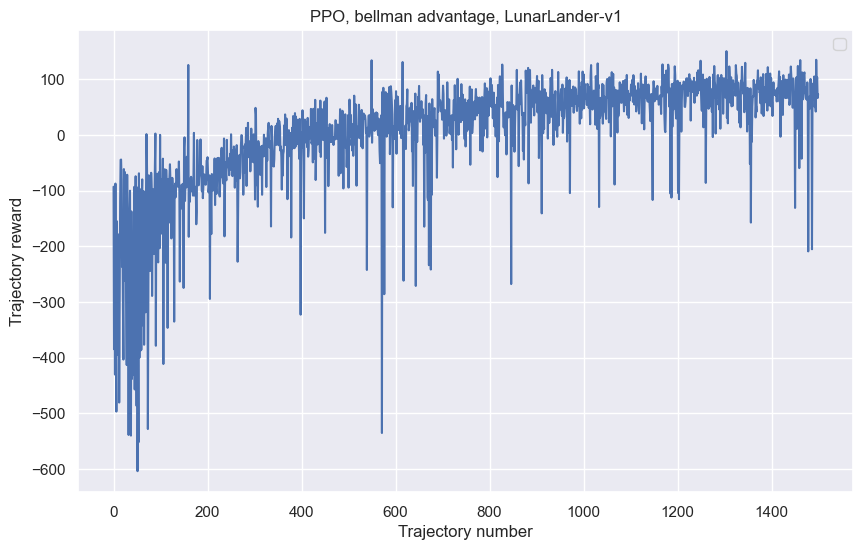

In [3]:
display(Image(filename="pics/ppo_bellman_lander.png"))

Валидация:

**PPO, bellman advantage, validation_score: 109.5668648926394**

## Задание 3

Написать PPO для работы в средах с конечным пространствам действий и решить Acrobot.

В случае непрерывного пространства действий мы пользовались представлением политики вида:

$$
\pi^{\eta} (a|s) = \mathcal{N} (a | \nu^{\eta} (s), \sigma)
$$

Теперь, имея дело с конечным пространством действий, будем представлять политику в виде:

$$
\pi^{\eta} (a|s) = \text{Softmax} (F^{\eta} (s))
$$

В реализации меняем процесс получения предсказания (добавляем Softmax) и семплирование из распределения:

```python
logits = self.pi_model(states)
probs = self.softmax(logits)

dist = Categorical(probs)
old_log_probs = dist.log_prob(actions).detach()
```

Для обучения понадобилось чуть больше эпизодов и эпох во время fit, также использовался default advantage:

```python
episode_n = 100
trajectory_n = 20
epoch_n = 30
```

График обучения:

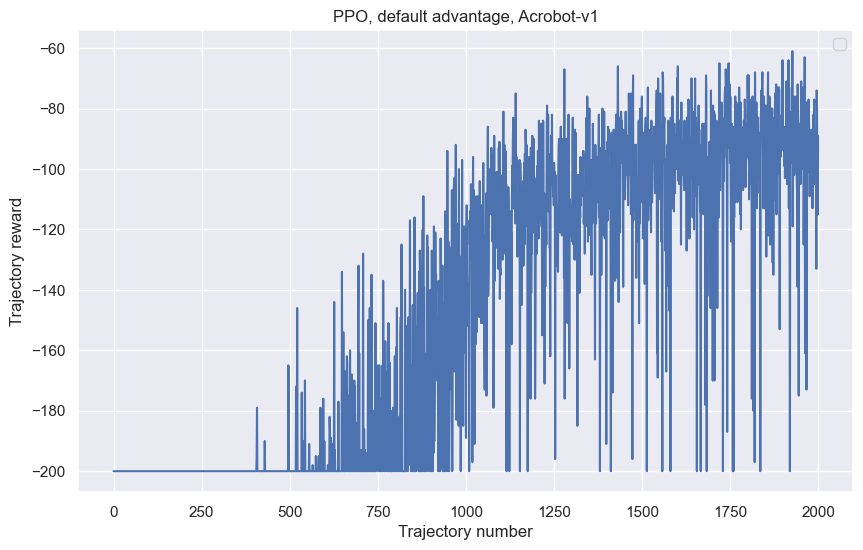

In [4]:
display(Image(filename="pics/ppo_default_acrobot.png"))

Валидация:

**PPO, bellman advantage, validation_score: -98.2**